# Traffic Fines Dataset

In [1]:
import pm4py
import pandas as pd
import random
from tqdm import tqdm
random.seed(4242)
import sys
sys.path.append("../..")
from experiments.dataframetocapnp import dataframeToMessage
from experiments.dataframetocapnp import dataframeFromMessage
from experiments.evaluation import Evaluator
import matplotlib.pyplot as plt

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /root/.vscode-server/bin/abd2f3db4bdb28f9e95536dfa84d8479f1eb312d


In [2]:
import capnp
capnp.remove_import_hook()
interface_capnp = capnp.load("../../cpp-tool/capnproto/interface.capnp", imports=["/usr/local/include"])

In [3]:
log = pm4py.read_xes("../datasets/Road_Traffic_Fine_Management_Process.xes")

/usr/local/lib/python3.9/dist-packages/pm4py/util/dt_parsing/parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 150370/150370 [00:23<00:00, 6536.42it/s]


## Data exploration

In [4]:
log.shape

(561470, 16)

In [5]:
log.columns

Index(['amount', 'org:resource', 'dismissal', 'concept:name', 'vehicleClass',
       'totalPaymentAmount', 'lifecycle:transition', 'time:timestamp',
       'article', 'points', 'case:concept:name', 'expense', 'notificationType',
       'lastSent', 'paymentAmount', 'matricola'],
      dtype='object')

In [6]:
log.isna().sum()

amount                  331240
org:resource            410545
dismissal               406404
concept:name                 0
vehicleClass            411100
totalPaymentAmount      333499
lifecycle:transition         0
time:timestamp               0
article                 411100
points                  411100
case:concept:name            0
expense                 457483
notificationType        481610
lastSent                483241
paymentAmount           483869
matricola               560915
dtype: int64

In [7]:
# ensure that events are correctly ordered through time
log.sort_values("time:timestamp", axis="rows", inplace=True)

In [8]:
set(log["lifecycle:transition"])

{'complete'}

In [9]:
log["matricola"].describe()

count    555.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: matricola, dtype: float64

In [10]:
# remove columns that are useless for learning data modification rules
log.drop(["lifecycle:transition", "time:timestamp", "matricola"], axis="columns", inplace=True)

In [11]:
# make article column categorical
log.article = log.article.astype(pd.Int64Dtype()).astype(str)
log.loc[log.article == "<NA>", "article"] = float("nan")
log.article

429367    158
431898    158
436195    158
436201    158
436206    158
         ... 
428728    NaN
428630    NaN
427802    NaN
427808    NaN
428786    NaN
Name: article, Length: 561470, dtype: object

In [12]:
# filter log for a smaller training and test set
allCaseIds = sorted(set(log["case:concept:name"]))
subsetCaseIds = random.sample(allCaseIds, len(allCaseIds) // 5)

nonTrainingCaseIds = sorted(set(log["case:concept:name"]).difference(subsetCaseIds))
testCaseIds = random.sample(nonTrainingCaseIds, len(nonTrainingCaseIds) // 4)
testLog = log[log["case:concept:name"].isin(testCaseIds)]

log = log[log["case:concept:name"].isin(subsetCaseIds)]
log.shape

(112245, 13)

## Convert to capnp message

In [13]:
eventLogMessage = dataframeToMessage(log)

Constructing traces: 100%|██████████| 30074/30074 [06:07<00:00, 81.92it/s]


## Finding model of data modification rules

In [14]:
client = capnp.TwoPartyClient("cpp-tool:21654")
processDataUpdates = client.bootstrap().cast_as(interface_capnp.ProcessDataUpdates)

In [15]:
modelPromise = processDataUpdates.findModel(eventLogMessage)
foundModel = modelPromise.wait().model
print(processDataUpdates.modelToString(foundModel).wait().string)

IF NOT (article = 142) THEN amount = 35.000000
IF org:resource = 29 THEN article IN {142}
IF NOT (vehicleClass = R) THEN concept:name IN {Create Fine}
IF concept:name: Add penalty -> Send Appeal to Prefecture THEN dismissal IN {#}
IF NOT (concept:name: Insert Fine Notification -> Send Fine) THEN expense = 13.500000
IF notificationType = C THEN lastSent IN {C}
IF concept:name = Appeal to Judge THEN org:resource IN {0}
IF totalPaymentAmount = 35.000000 THEN paymentAmount = 35.000000
IF amount <= 68.770000 THEN points = 0.000000
IF concept:name = Create Fine THEN totalPaymentAmount = 0.000000
IF concept:name = Add penalty THEN amount = 71.500000
IF vehicleClass = C THEN article IN {171}
IF notificationType = P THEN concept:name IN {Insert Fine Notification}
IF concept:name: Insert Fine Notification -> Send Fine THEN expense = 0.000000
IF totalPaymentAmount = 36.000000 THEN paymentAmount = 36.000000
IF 143.000000 <= amount THEN points IN [0.000000, 10.000000]
IF concept:name: Payment -> Pa

| MDL score estimate | dataset proportion | runtime |
| ------------------ | ------------------ | ------- |
| yes | 1/10 | 1h 24min 45.5s |
| no | 1/5 | 6h 57min 49.2s |
| yes | 1/5 | 4h 38min 32.3s |

In [16]:
modelFileName = "trafficFinesModel.bin"
with open(modelFileName, "wb") as file:
    foundModel.as_builder().write(file)

## Relationship between amount and points

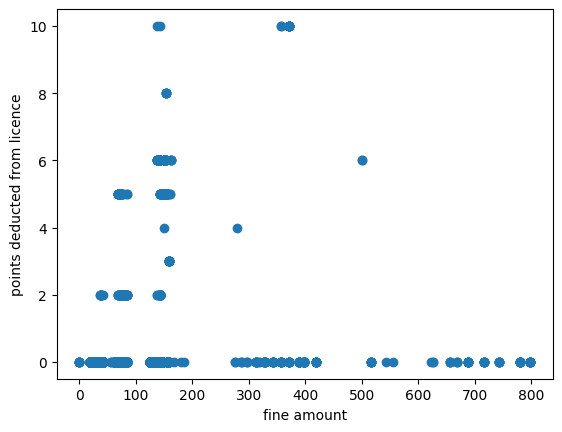

In [12]:
import matplotlib.pyplot as plt
amount = log["amount"]
points = log["points"]
mask = amount < 1500
amount = amount[mask]
points = points[mask]
plt.scatter(amount, points)
plt.xlabel("fine amount")
plt.ylabel("points deducted from licence")
plt.show()

In [17]:
# export to CSV for LaTeX
exportFrame = pd.DataFrame({"amount": amount, "points": points})
exportFrame.drop_duplicates(inplace=True)
exportFrame.dropna(inplace=True)
exportFrame.to_csv("../../document/figs/traffic-points-vs-amount.csv", index=False)

## Predicting on a test set

In [3]:
# load model
fileName = "trafficFinesModelWithEstimate.bin"
with open(fileName, "rb") as file:
    model = interface_capnp.RuleModel.read(file)
# create empty model
emptyModel = interface_capnp.RuleModel.new_message(rules=[], variables=list(model.as_builder().variables))

In [4]:
client = capnp.TwoPartyClient("cpp-tool:21654")
processDataUpdates = client.bootstrap().cast_as(interface_capnp.ProcessDataUpdates)

In [5]:
evaluator = Evaluator(interface_capnp, processDataUpdates)

In [6]:
with open("trafficFinesTrainingSet.bin", "rb") as file:
    eventLogMessage = interface_capnp.EventLog.read(file).as_builder()
with open("trafficFinesTestSet.bin", "rb") as file:
    testSetMessage = interface_capnp.EventLog.read(file).as_builder()

In [7]:
testSetMetrics = pd.read_csv("trafficFinesTestSetMetrics.csv")
aggregatedMetrics = evaluator.aggregateMetrics(testSetMetrics, ["model"], ["F1", "RMSE"])
aggregatedMetrics

F1                           RMSE                      
         lowIqr    midIqr   highIqr     lowIqr     midIqr    highIqr
model                                                               
empty  0.178175  0.178596  0.178956  95.478462  95.686477  95.989085
my     0.180271  0.180867  0.181768  54.300830  54.710562  54.911612

We are slightly better at predicting categorical variables but significantly better at predicting numerical ones.
This happens since only 21 of the 117 rules (17.9%) predict categorical variables.

## Investigating poor performance on categorical attributes

In [8]:
logDataframe = dataframeFromMessage(testSetMessage, disableProgressBar=True)
logDataframe.sort_values("case:concept:name", inplace=True)

categoricalVariables = []
for variable in logDataframe.columns:
    if evaluator.getVariableType(variable, testSetMessage.variables) == "categorical":
        categoricalVariables.append(variable)

In [9]:
def mergeScoresInSingleColumn(dataframe, columnNames, attributeName):
    allColumns = [dataframe[x] for x in columnNames]
    allScores = pd.concat(allColumns, ignore_index=True)
    allModels = pd.concat([dataframe["model"]] * len(columnNames), ignore_index=True)
    numberOfScores = dataframe.shape[0]
    allAttributes = pd.Series([x for x in columnNames for i in range(numberOfScores)])
    allExperimentIds = pd.Series([x for i in range(len(columnNames)) for x in range(numberOfScores // 2)
                                  for j in range(2)])
    return pd.DataFrame({"model": allModels, "experiment": allExperimentIds,
                         attributeName: allAttributes, "score": allScores})

In [10]:
perVariableF1Scores = pd.read_csv("trafficFinesPerVariableF1.csv")
# only look at F1 score differences
perVariableF1Scores = perVariableF1Scores.groupby(["experiment", "variable"])[["score"]].agg(
    lambda x: x.iloc[1] - x.iloc[0])
aggregatedF1Scores = evaluator.aggregateMetrics(perVariableF1Scores, ["variable"], ["score"])
aggregatedF1Scores

score                    
                    lowIqr    midIqr   highIqr
variable                                      
article           0.002155  0.002899  0.003381
concept:name      0.006404  0.006754  0.007258
dismissal        -0.001339 -0.000119  0.002214
lastSent          0.002277  0.004254  0.007249
notificationType -0.000032  0.000032  0.000095
org:resource     -0.000173  0.000275  0.000542
vehicleClass     -0.000886  0.000416  0.003297

For the predicted variables article, concept:name, lastSent we are better than the empty model.
For the also predicted variables dismissal and org:resource this is not the case.
However, we only predict these with a single rule which could be spurious.

In [11]:
articles = logDataframe.article.unique()[1:]
articles

array(['157', '7', '158', '145', '23', '20', '180', '193', '80', '171',
       '21', '172', '170', '97', '94', '149', '181', '41', '191', '143',
       '146', '154', '142', '169', '125', '148', '173', '72', '126',
       '102', '43', '136', '116', '189', '152', '188', '71', '141', '15',
       '164', '192', '213', '40', '144', '156', '401', '155'],
      dtype=object)

In [12]:
articleF1Scores = pd.read_csv("trafficFinesArticleF1.csv")
# rename non-predicted articles
articleF1Scores.loc[~articleF1Scores.article.isin([142, 157, 171]), "article"] = "other"
# only look at F1 score differences
articleF1Scores = articleF1Scores.groupby(["experiment", "article"])[["score"]].agg(
    lambda x: x.iloc[1] - x.iloc[0])
aggregatedArticleF1Scores = evaluator.aggregateMetrics(articleF1Scores, ["article"], ["score"])
aggregatedArticleF1Scores

score                    
           lowIqr    midIqr   highIqr
article                              
142      0.061379  0.066042  0.070992
157      0.070725  0.073088  0.075272
171      0.015817  0.017094  0.022727
other   -0.007695 -0.003236 -0.000083

For the predicted articles (142, 157, 171), our model is a lot better than the empty one.

In [16]:
articlePrecisionRecall = pd.read_csv("trafficFinesArticlePrecisionRecall.csv")
# rename non-predicted articles
articlePrecisionRecall.loc[~articlePrecisionRecall.article.isin([142, 157, 171]), "article"] = "other"
aggregatedArticlePrecisionRecall = evaluator.aggregateMetrics(articlePrecisionRecall, ["article", "model"], ["precision", "recall"])
aggregatedArticlePrecisionRecall

precision                        recall                    
                 lowIqr    midIqr   highIqr    lowIqr    midIqr   highIqr
article model                                                            
142     empty  0.029851  0.036232  0.042342  0.029851  0.035119  0.041264
        my     0.096417  0.099180  0.101401  0.102722  0.106234  0.107989
157     empty  0.452476  0.454935  0.459674  0.446779  0.450512  0.453953
        my     0.498308  0.500495  0.501311  0.552800  0.555271  0.557083
171     empty  0.000000  0.000000  0.007194  0.000000  0.000000  0.008475
        my     0.012605  0.013393  0.017168  0.025424  0.025424  0.033898
other   empty  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
        my     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000

Our expectation that my model predicts with high precision but low recall is wrong.

## Generalization performance

In [3]:
client = capnp.TwoPartyClient("cpp-tool:21654")
processDataUpdates = client.bootstrap().cast_as(interface_capnp.ProcessDataUpdates)
evaluator = Evaluator(interface_capnp, processDataUpdates)

In [4]:
# load model
fileName = "trafficFinesModelWithEstimate.bin"
with open(fileName, "rb") as file:
    model = interface_capnp.RuleModel.read(file)

In [5]:
# load baseline model
fileName = "trafficFinesBaselineModel.bin"
with open(fileName, "rb") as file:
    baselineModel = interface_capnp.RuleModel.read(file)

In [6]:
categoricalScores = pd.DataFrame({"model": [], "dataset": [], "ruleNumber": [],
                                  "targetVariable": [], "f1Score": []})
numericalScores = pd.DataFrame({"model": [], "dataset": [], "ruleNumber": [],
                                "targetVariable": [], "RMSE": []})

### Visualizing results

In [7]:
numericalScores = pd.read_csv("numericalScores.csv")
categoricalScores = pd.read_csv("categoricalScores.csv")
numericalScores.ruleNumber = numericalScores.ruleNumber.astype("int32")
categoricalScores.ruleNumber = categoricalScores.ruleNumber.astype("int32")

#### Scatter plots

In [8]:
def prepareScatterPlot(table):
    trainingFilter = (table.dataset == "training") & (table.model == "my")
    testFilter = (table.dataset == "test") & (table.model == "my")
    return table[trainingFilter].merge(table[testFilter], on="ruleNumber",
                                       suffixes=("_training", "_test"))

In [9]:

numericalScatter = prepareScatterPlot(numericalScores)
categoricalScatter = prepareScatterPlot(categoricalScores)

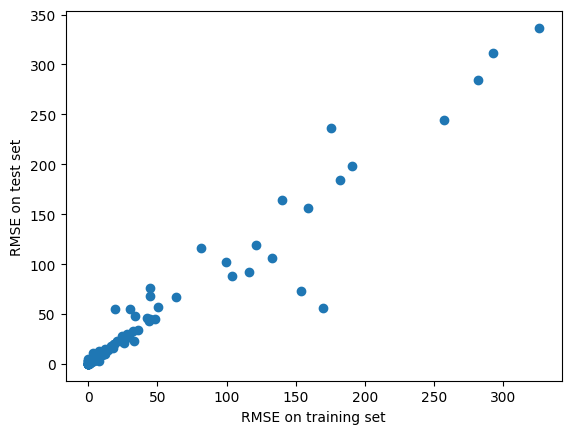

In [10]:
plt.scatter(numericalScatter.RMSE_training, numericalScatter.RMSE_test)
plt.xlabel("RMSE on training set")
plt.ylabel("RMSE on test set")
plt.show()

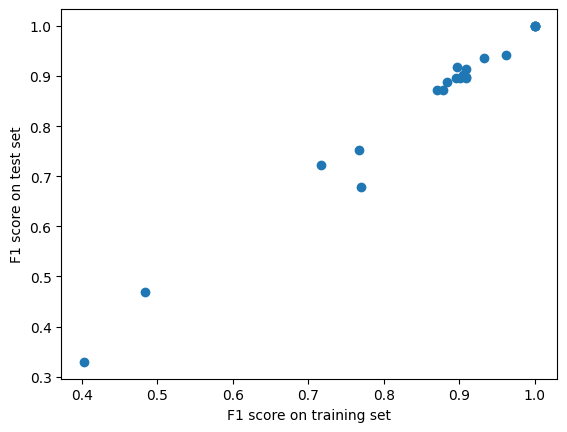

In [11]:
plt.scatter(categoricalScatter.f1Score_training, categoricalScatter.f1Score_test)
plt.xlabel("F1 score on training set")
plt.ylabel("F1 score on test set")
plt.show()

#### Line plots

In [8]:
import numpy as np
def sortScoresForPlot(table, scoreColumn, desc=False):
    argsort = np.argsort(table[scoreColumn][table.dataset == "training"])
    if desc:
        argsort = np.flip(argsort)
    sortedRuleIds = list(np.argsort(argsort))
    table.loc[(table.dataset == "training") & (table.model == "my"), "ruleNumber"] = sortedRuleIds
    table.loc[(table.dataset == "test") & (table.model == "my"), "ruleNumber"] = sortedRuleIds
    table = table.sort_values("ruleNumber")
    return table

In [9]:
def joinBaselineRules(table):
    joinedTable = table[table.model == "my"].merge(table[table.model == "baseline"], how="left",
                                                   on="targetVariable", suffixes=("", "Baseline"))
    return joinedTable

In [10]:
numericalScores = joinBaselineRules(sortScoresForPlot(numericalScores, "RMSE", desc=True))
categoricalScores = joinBaselineRules(sortScoresForPlot(categoricalScores, "f1Score"))

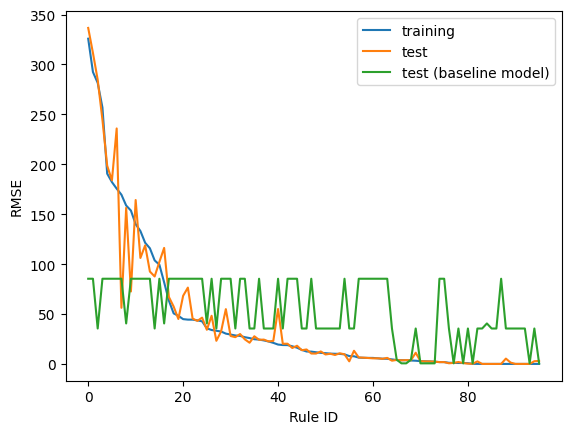

In [11]:
plt.plot(numericalScores.ruleNumber[numericalScores.dataset == "training"],
         numericalScores.RMSE[numericalScores.dataset == "training"])
plt.plot(numericalScores.ruleNumber[numericalScores.dataset == "test"],
         numericalScores.RMSE[numericalScores.dataset == "test"])
plt.plot(numericalScores.ruleNumber[numericalScores.dataset == "test"],
         numericalScores.RMSEBaseline[numericalScores.dataset == "test"])
plt.legend(["training", "test", "test (baseline model)"])
plt.xlabel("Rule ID")
plt.ylabel("RMSE")
plt.show()

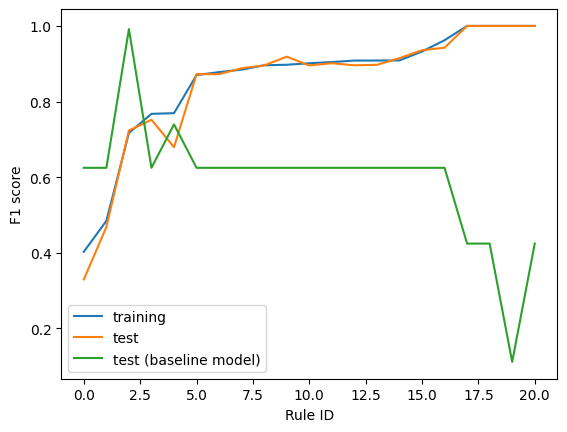

In [12]:
plt.plot(categoricalScores.ruleNumber[categoricalScores.dataset == "training"],
         categoricalScores.f1Score[categoricalScores.dataset == "training"])
plt.plot(categoricalScores.ruleNumber[categoricalScores.dataset == "test"],
         categoricalScores.f1Score[categoricalScores.dataset == "test"])
plt.plot(categoricalScores.ruleNumber[categoricalScores.dataset == "test"],
         categoricalScores.f1ScoreBaseline[categoricalScores.dataset == "test"])
plt.legend(["training", "test", "test (baseline model)"])
plt.xlabel("Rule ID")
plt.ylabel("F1 score")
plt.show()

#### Latex exports

In [13]:
numericalScores.to_csv("trafficFinesGeneralizationNumerical.csv", index=False,
                       columns=["dataset", "ruleNumber", "RMSE", "RMSEBaseline"])

In [14]:
categoricalScores.to_csv("trafficFinesGeneralizationCategorical.csv", index=False,
                       columns=["dataset", "ruleNumber", "f1Score", "f1ScoreBaseline"])